# The Big Bang Theory Viewership

**The Big Bang Theory** is an American television sitcom created and produced by *Chuck Lorre* and *Bill Prady* for CBS. The episode titles of The Big Bang Theory always start with "The" and resemble the name of a scientific principle, theory or experiment, whimsically referencing a plot point or quirk in that episode. For example 

During the course of the series, **279 episodes** of The Big Bang Theory aired, between September 24, 2007, and May 16, 2019. All seasons and episodes have been released on DVD, Blu-ray, and Max.


Source: [Wikipedia](https://en.wikipedia.org/wiki/The_Big_Bang_Theory)


<img src="TBBT_logo.svg" width="200px" alt="Description of the image">

In [1]:
import requests

r = requests.get('https://en.wikipedia.org/wiki/List_of_The_Big_Bang_Theory_episodes')

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
from io import StringIO
import re

def normalize_column_name(col_name):
    # to snake_case
    col_name = str(col_name).lower()
    col_name = re.sub(r'[.\(\)]', '', col_name)
    col_name = re.sub(r'\s+', '_', col_name)
    return col_name.strip('_')

def get_tables_from_soup_to_dfs(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    tables = soup.find_all('table')

    dataframes = []
    for i, table in enumerate(tables):
        try:
            df = pd.read_html(StringIO(str(table)))[0]
            dataframes.append(df)
        except ValueError as e:
            continue
    return dataframes

def find_viewership_tables(dataframes, required_columns):
    required_columns = [normalize_column_name(col) for col in required_columns]

    similar_tables = []
    for df in dataframes:
        if not df.empty:
            df.columns = [normalize_column_name(col) for col in df.columns]
    
            if all(col in df.columns for col in required_columns):
                similar_tables.append(df)
    return similar_tables


target_headers = [
    "No. overall",
    "No. in season",
    "Title",
    "Directed by",
    "Written by",
    "Original release date",
    "Prod. code",
    "U.S. viewers (millions)"
]


all_dataframes = get_tables_from_soup_to_dfs(r.text)
print(f"Found {len(all_dataframes)} tables in the HTML from wikipedia.")

matching_tables = find_viewership_tables(all_dataframes, target_headers)

print(f"\nFound {len(matching_tables)} viewership tables {'as expected' if len(matching_tables)==12 else ', maybe there was an error'}.")


Found 16 tables in the HTML from wikipedia.

Found 12 viewership tables as expected.


In [3]:
for season_num, df in enumerate(matching_tables):
    df['season'] = season_num+1

df = pd.concat(matching_tables)

df['no_overall'] = pd.to_numeric(df['no_overall'], errors='raise')
df['no_in_season'] = pd.to_numeric(df['no_in_season'], errors='raise')

df['viewers'] = (df['us_viewers_millions'].str.replace('\[\d+\]', '', regex=True).astype(float)*1000000).astype(int)
df['release_date'] = pd.to_datetime(df['original_release_date'])

last_episode_numbers = df.groupby('season')['no_in_season'].max()

df['is_last_episode'] = df.apply(
    lambda row: row['no_in_season'] == last_episode_numbers.loc[row['season']],
    axis=1)


In [4]:
df

,no_overall,no_in_season,title,directed_by,written_by,original_release_date,prod_code,us_viewers_millions,season,viewers,release_date,is_last_episode
0,1,1,"""Pilot""",James Burrows,Chuck Lorre & Bill Prady,"September 24, 2007",276023,9.52[14],1,9520000,2007-09-24,False
1,2,2,"""The Big Bran Hypothesis""",Mark Cendrowski,Story by : Chuck Lorre & Bill Prady Teleplay b...,"October 1, 2007",3T6601,8.50[15],1,8500000,2007-10-01,False
2,3,3,"""The Fuzzy Boots Corollary""",Mark Cendrowski,Story by : Chuck Lorre Teleplay by : Bill Prad...,"October 8, 2007",3T6602,8.35[16],1,8350000,2007-10-08,False
3,4,4,"""The Luminous Fish Effect""",Mark Cendrowski,Story by : Chuck Lorre & Bill Prady Teleplay b...,"October 15, 2007",3T6603,7.94[17],1,7940000,2007-10-15,False
4,5,5,"""The Hamburger Postulate""",Andrew D. Weyman,Story by : Jennifer Glickman Teleplay by : Dav...,"October 22, 2007",3T6604,8.81[18],1,8810000,2007-10-22,False
...,...,...,...,...,...,...,...,...,...,...,...,...
19,275,20,"""The Decision Reverberation""",Mark Cendrowski,Story by : Steven Molaro & Steve Holland & Tar...,"April 25, 2019",T12.16020,11.84[285],12,11840000,2019-04-25,False
20,276,21,"""The Plagiarism Schism""",Nikki Lorre,Story by : Eric Kaplan & Maria Ferrari & Adam ...,"May 2, 2019",T12.16021,12.48[286],12,12480000,2019-05-02,False
21,277,22,"""The Maternal Conclusion""",Kristy Cecil,Story by : Steve Holland & Eric Kaplan & Jerem...,"May 9, 2019",T12.16022,12.59[287],12,12590000,2019-05-09,False
22,278,23,"""The Change Constant""",Mark Cendrowski,Chuck Lorre & Steve Holland & Steven Molaro & ...,"May 16, 2019",T12.16023,18.52[288],12,18520000,2019-05-16,False


## Basic statistics per season

In [5]:
df.groupby('season')['viewers'].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,17.0,8.336471e+06,7.036862e+05,7340000.0,7790000.0,8410000.0,8810000.0,9520000.0
2,23.0,1.007000e+07,9.593558e+05,8600000.0,9365000.0,9760000.0,10665000.0,12720000.0
3,23.0,1.414565e+07,1.329295e+06,11630000.0,13250000.0,13730000.0,15280000.0,16320000.0
4,24.0,1.255833e+07,1.054059e+06,10500000.0,12002500.0,12690000.0,13142500.0,14040000.0
5,24.0,1.488125e+07,1.096133e+06,12650000.0,13950000.0,14935000.0,15912500.0,16540000.0
6,24.0,1.679917e+07,1.401164e+06,14230000.0,15797500.0,16725000.0,17630000.0,20000000.0
7,24.0,1.769500e+07,1.408481e+06,14420000.0,16850000.0,17705000.0,18460000.0,20440000.0
8,24.0,1.615583e+07,1.367730e+06,13850000.0,14810000.0,16189999.5,17130000.0,18300000.0
9,24.0,1.521625e+07,1.099564e+06,13220000.0,14680000.0,15210000.0,15775000.0,18200000.0


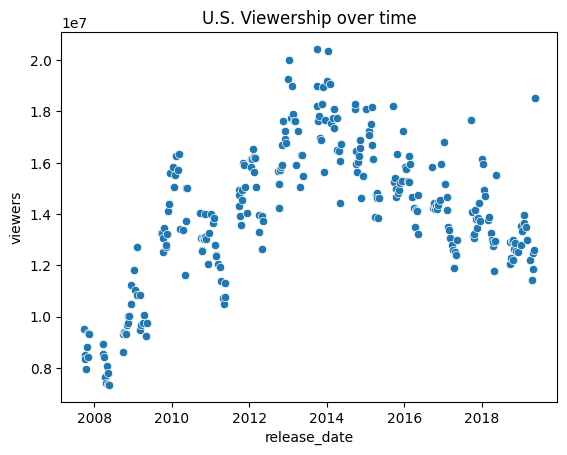

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='release_date', y='viewers', data=df, marker='o')
plt.title('U.S. Viewership over time')
plt.show()


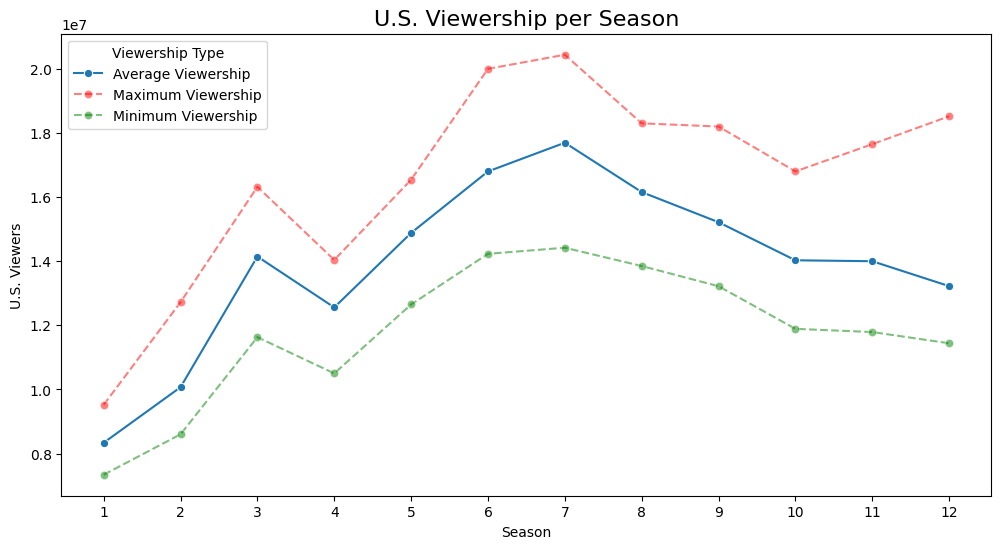

In [7]:
season_avg_viewership = df.groupby('season')['viewers'].mean().reset_index()
season_max_viewership = df.groupby('season')['viewers'].max().reset_index()
season_min_viewership = df.groupby('season')['viewers'].min().reset_index()

plt.figure(figsize=(12, 6))

sns.lineplot(x='season', y='viewers', data=season_avg_viewership, marker='o', label='Average Viewership')
sns.lineplot(x='season', y='viewers', data=season_max_viewership, marker='o', linestyle='--', color='red', alpha=0.5, label='Maximum Viewership')
sns.lineplot(x='season', y='viewers', data=season_min_viewership, marker='o', linestyle='--', color='green', alpha=0.5, label='Minimum Viewership')

plt.title('U.S. Viewership per Season', fontsize=16)
plt.xlabel('Season')
plt.ylabel('U.S. Viewers')
plt.xticks(season_avg_viewership['season'])

plt.legend(title='Viewership Type') 
plt.show()


# Changes in viewership

The largest nominal increase in viewership was in season 3, with over 4 million new viewers on average, 40% mor than season 2.

The largest decrease was in season 4 with 1,5 million views less than season 3, a 11% decrease.

From that point, the show had continuous growth up until season 7. From season 8, viewership started to decrease again until the show finished. 

These number reflect the views on average, if we take a look at the maximum views as shown in the previous graph, we can see that the last two seasons reached quite a high number of views for its last episodes.



In [8]:
pd.set_option('display.float_format', '{:.1f}'.format)

season_avg_viewership = df.groupby('season')['viewers'].mean().rename('avg_viewers').reset_index()
season_avg_viewership['viewership_change'] = season_avg_viewership['avg_viewers'].diff()
season_avg_viewership['viewership_change_%'] = \
    (season_avg_viewership['viewership_change'] / season_avg_viewership['avg_viewers'].shift(1) * 100).round(2)

display(season_avg_viewership)
pd.reset_option('display.float_format')


,season,avg_viewers,viewership_change,viewership_change_%
0,1,8336470.6,NaN,NaN
1,2,10070000.0,1733529.4,20.8
2,3,14145652.2,4075652.2,40.5
3,4,12558333.3,-1587318.8,-11.2
4,5,14881249.9,2322916.6,18.5
5,6,16799166.7,1917916.8,12.9
6,7,17695000.0,895833.3,5.3
7,8,16155833.2,-1539166.7,-8.7
8,9,15216250.0,-939583.2,-5.8
9,10,14028333.3,-1187916.7,-7.8


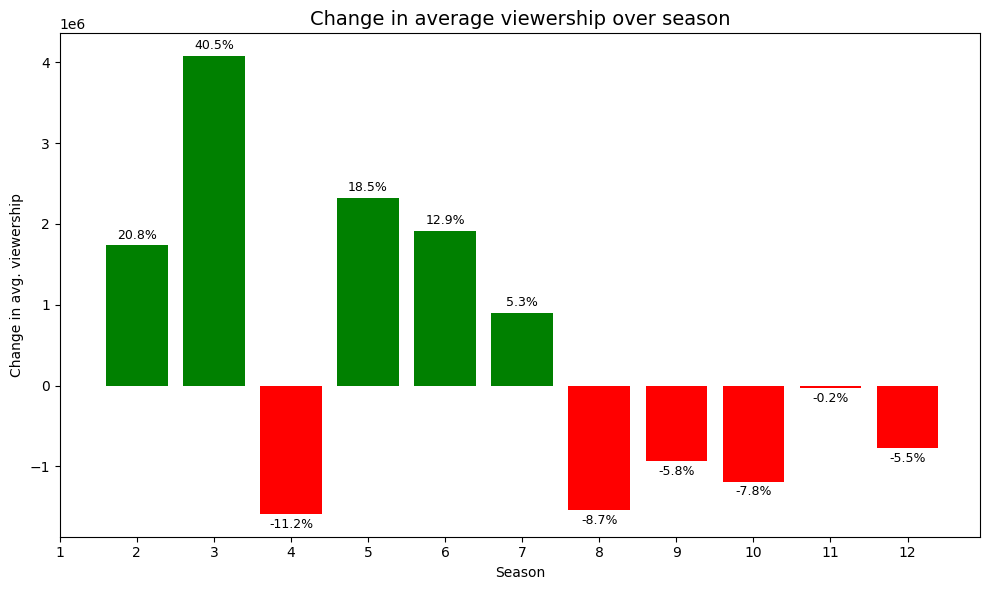

In [9]:
plt.figure(figsize=(10, 6))

plot_data = season_avg_viewership.dropna(subset=['viewership_change'])

bars = plt.bar(plot_data['season'], plot_data['viewership_change'],
               color=['red' if x < 0 else 'green' for x in plot_data['viewership_change']])

plt.xlabel("Season")
plt.ylabel("Change in avg. viewership")
plt.title("Change in average viewership over season",
          fontsize=14,)

plt.xticks(season_avg_viewership['season'])

for i, row in plot_data.iterrows():
    plt.annotate(f'{row["viewership_change_%"]:.1f}%',
                 (row['season'], row['viewership_change']),
                 textcoords="offset points", 
                 xytext=(0, 5 if row['viewership_change']>0 else -10), 
                 ha='center', 
                 fontsize=9)
    
plt.tight_layout() 
plt.show()